# Working with facenet-pytorch and decord

As of version 2.2, the MTCNN module of facenet-pytorch can work directly with images represented as numpy arrays. This change achieves higher performance when reading video frames with either `cv2.VideoCapture` or `decord.VideoReader` as it avoids conversion to PIL format. A number of additional enhancements have been added to improve detection efficiency.

**This notebook demonstrates how to detect every face in every frame in every video of the dataset at full resolution in approximately 3 hours.**

---

**UPDATE (2020-03-04):** Video reading has been switched from cv2 to decord for improved performance.

---

In [1]:
%%capture
# Install facenet-pytorch (with internet use "pip install facenet-pytorch")
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.9-py3-none-any.whl
!cp /kaggle/input/decord/install.sh . && chmod  +x install.sh && ./install.sh

## Imports

In [2]:
import sys, os
sys.path.insert(0,'/kaggle/working/reader/python')

from facenet_pytorch import MTCNN
import torch
import cupy
from decord import VideoReader, gpu
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## The FastMTCNN Class

The following class implements a strided version of MTCNN. See [here](https://www.kaggle.com/timesler/fast-mtcnn-detector-55-fps-at-full-resolution) for the original implementation.

In [3]:
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, stride, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.stride = stride
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames):
        """Detect faces in frames using strided MTCNN."""
                      
        boxes, probs = self.mtcnn.detect(frames[::self.stride])

        faces = []
        probs_out = []
        frame_index = []
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box, prob in zip(boxes[box_ind], probs[box_ind]):
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]].copy())
                probs_out.append(prob)
                frame_index.append(i)
                
        
        return faces, probs, frame_index

## Define face detector

The following face detector can detect all faces in a video in approximately 2.8 seconds, allowing all videos in the public test set to be processed in 2.8 * 4000 = 11200 seconds = 3.1 hours.

In [4]:
fast_mtcnn = FastMTCNN(
    stride=10,
    margin=20,
    factor=0.6,
    keep_all=True,
    device=device,
    thresholds=[0.6, 0.7, 0.98]
)

## Process all videos

In [5]:
%%time

def mean_detection_prob(prob):
    cnt_p = 0
    sum_p = 0
    for p in prob:
        for pp in p:
            if pp is not None:
                cnt_p += 1
                sum_p += pp
    return sum_p / cnt_p


def get_frames(filename, batch_size=30):
    v_cap = VideoReader(filename, ctx=gpu())
    v_len = len(v_cap)

    frames = []
    for i in range(0, v_len, batch_size):
        batch = v_cap.get_batch(range(i, min(i + batch_size, v_len - 1))).asnumpy()
        frames.extend(batch.copy())
    
    frames = np.array(frames)
    
    del v_cap, v_len, batch
    
    return frames


filenames = glob.glob('/kaggle/input/deepfake-detection-challenge/test_videos/*.mp4')

num_faces = 0
probs = []
indexes = []
pbar = tqdm(filenames)
for filename in pbar:
    frames = get_frames(filename)

    faces, prob, index = fast_mtcnn(frames)        
    probs.append(mean_detection_prob(prob))

    num_faces += len(faces)
    pbar.set_description(f'Faces found: {num_faces}')

    del frames


CPU times: user 14min 3s, sys: 9min 33s, total: 23min 37s
Wall time: 22min 17s


,filename,label
0,iorbtaarte.mp4,0.295694
1,vnlzxqwthl.mp4,0.255125
2,gqnaxievjx.mp4,0.540020
3,sjkfxrlxxs.mp4,0.546456
4,eppyqpgewp.mp4,0.399687
...,...,...
395,pxjkzvqomp.mp4,0.261632
396,rnfcjxynfa.mp4,0.296991
397,hxwtsaydal.mp4,0.564269
398,bzvzpwrabw.mp4,0.533757


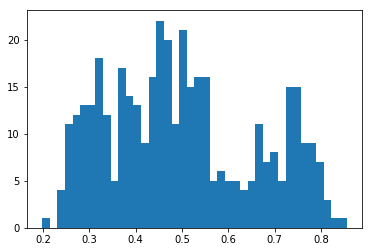

In [6]:
probs = np.asarray(probs)
probs = np.clip((1 - probs) ** (1 / 6) * 1.7, 0.0, 1.0)
plt.hist(probs, 40);

filenames = [os.path.basename(f) for f in filenames]

submission = pd.DataFrame({'filename': filenames, 'label': probs})
submission.to_csv('submission.csv', index=False)
submission